<a href="https://colab.research.google.com/github/peeyushsinghal/EVA/blob/main/Copy_of_PyTorch_GradCAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! nvidia-smi

Wed Oct 19 14:11:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
%pip install captum timm shap grad-cam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.8 MB 4.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.6-py3-none-any.whl size=38261 sha256=964945bc3c4f0d2228451e74e62de9dd417e0ee15c36b7a3f4d0b73945307a78
  Stored in directory: /root/.cache/pip/wheels/a4/6a/11/fa213a7aaae1a99a800b86bdd1cc95bc9c7d7914b0859663b8
Successfully built grad-cam


In [ ]:
import timm
import urllib
import torch

import numpy as np

import torchvision.transforms as T
import torch.nn.functional as F

from PIL import Image

from matplotlib.colors import LinearSegmentedColormap

import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda")

In [ ]:
model = timm.create_model("resnet18", pretrained=True)
model.eval()
model = model.to(device)

In [ ]:
# Download human-readable labels for ImageNet.
# get the classnames
url, filename = (
    "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt",
    "imagenet_classes.txt",
)
urllib.request.urlretrieve(url, filename)
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]


In [ ]:
! wget -O cat.jpeg "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSKr5wT7rfkjkGvNeqgXjBmarC5ZNoZs-H2uMpML8O7Q4F9W-IlUQibBT6IPqyvX45NOgw&usqp=CAU"

--2022-10-19 14:11:53--  https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSKr5wT7rfkjkGvNeqgXjBmarC5ZNoZs-H2uMpML8O7Q4F9W-IlUQibBT6IPqyvX45NOgw&usqp=CAU
Resolving encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)... 173.194.195.100, 173.194.195.113, 173.194.195.138, ...
Connecting to encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)|173.194.195.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6107 (6.0K) [image/jpeg]
Saving to: ‘cat.jpeg’

cat.jpeg            100%[===================>]   5.96K  --.-KB/s    in 0s      

2022-10-19 14:11:53 (76.9 MB/s) - ‘cat.jpeg’ saved [6107/6107]



In [ ]:
transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor()
])

transform_normalize = T.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
)

img = Image.open('cat.jpeg')

transformed_img = transform(img)

img_tensor = transform_normalize(transformed_img)
img_tensor = img_tensor.unsqueeze(0)

In [ ]:
img_tensor = img_tensor.to(device)
output = model(img_tensor)
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)

pred_label_idx.squeeze_()
predicted_label = categories[pred_label_idx.item()]
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')

Predicted: Egyptian cat ( 0.6638395190238953 )


In [ ]:
pred_label_idx

tensor(285, device='cuda:0')

## Captum Model Interpretation

In [ ]:
from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

In [ ]:
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')

integrated_gradients = IntegratedGradients(model)
attributions_ig = integrated_gradients.attribute(img_tensor, target=pred_label_idx, n_steps=200)

Predicted: Egyptian cat ( 0.6638395190238953 )


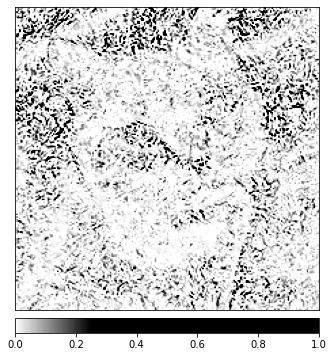

In [ ]:
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1)

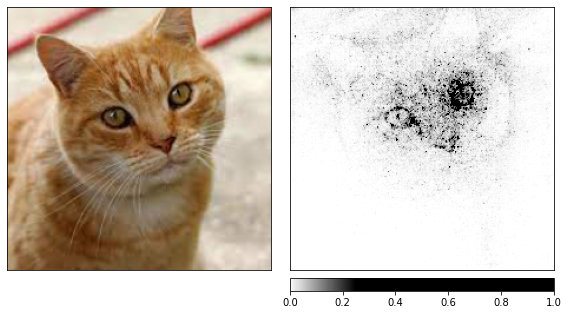

In [ ]:
noise_tunnel = NoiseTunnel(integrated_gradients)

attributions_ig_nt = noise_tunnel.attribute(img_tensor, nt_samples=10, nt_type='smoothgrad_sq', target=pred_label_idx)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

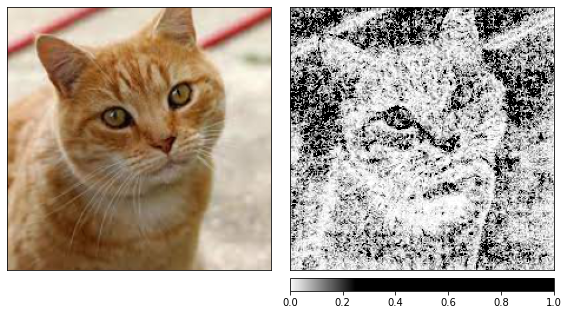

In [ ]:
torch.manual_seed(0)
np.random.seed(0)

gradient_shap = GradientShap(model)

# Defining baseline distribution of images
rand_img_dist = torch.cat([img_tensor * 0, img_tensor * 1])

attributions_gs = gradient_shap.attribute(img_tensor,
                                          n_samples=50,
                                          stdevs=0.0001,
                                          baselines=rand_img_dist,
                                          target=pred_label_idx)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_gs.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "absolute_value"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

In [ ]:
occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(img_tensor,
                                       strides = (3, 8, 8),
                                       target=pred_label_idx,
                                       sliding_window_shapes=(3,15, 15),
                                       baselines=0)

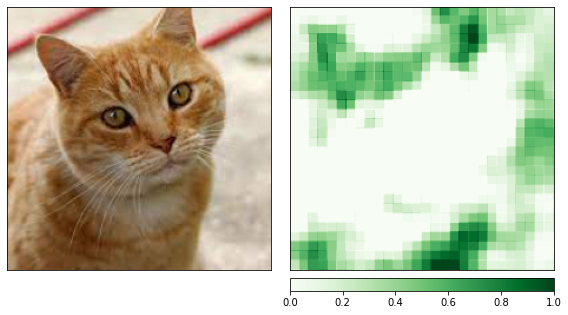

In [ ]:
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )

## SHAP

Works well where number of classes are less

In [ ]:
import shap

In [ ]:
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

img = Image.open('cat.jpeg')

img_tensor = transform(img)
img_tensor = img_tensor.unsqueeze(0)
img_tensor = img_tensor.to(device)

In [ ]:
model_out = model(img_tensor)
classes = torch.argmax(model_out, axis=1).cpu().numpy()
print(f'Classes: {classes}: {np.array(categories)[classes]}')

Classes: [285]: ['Egyptian cat']


In [ ]:
img_tensor.shape

torch.Size([1, 3, 224, 224])

In [ ]:
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]
inv_transform= T.Compose([
    T.Lambda(lambda x: x.permute(0, 3, 1, 2)),
    T.Normalize(
        mean = (-1 * np.array(mean) / np.array(std)).tolist(),
        std = (1 / np.array(std)).tolist()
    ),
    T.Lambda(lambda x: x.permute(0, 2, 3, 1)),
])

In [ ]:
def predict(imgs: torch.Tensor) -> torch.Tensor:
    imgs = torch.tensor(imgs)
    imgs = imgs.permute(0, 3, 1, 2)
    
    img_tensor = imgs.to(device)

    output = model(img_tensor)
    return output

In [ ]:
topk = 4
batch_size = 50
n_evals = 10000

# define a masker that is used to mask out partitions of the input image.
masker_blur = shap.maskers.Image("blur(128,128)", (224, 224, 3))

# create an explainer with model and image masker
explainer = shap.Explainer(predict, masker_blur, output_names=categories)

# feed only one image
# here we explain two images using 100 evaluations of the underlying model to estimate the SHAP values
image_np = Image.open("cat.jpeg")
img_tensor = transform(image_np)
img_tensor = img_tensor.unsqueeze(0)
img_tensor = img_tensor.permute(0, 2, 3, 1)

shap_values = explainer(img_tensor, max_evals=n_evals, batch_size=batch_size,
                        outputs=shap.Explanation.argsort.flip[:topk])

  0%|          | 0/9998 [00:00<?, ?it/s]

Partition explainer: 2it [00:52, 52.68s/it]               


In [ ]:
(shap_values.data.shape, shap_values.values.shape)

(torch.Size([1, 224, 224, 3]), (1, 224, 224, 3, 4))

In [ ]:
shap_values.data = inv_transform(shap_values.data).cpu().numpy()[0]

In [ ]:
shap_values.values = [val for val in np.moveaxis(shap_values.values[0], -1, 0)]

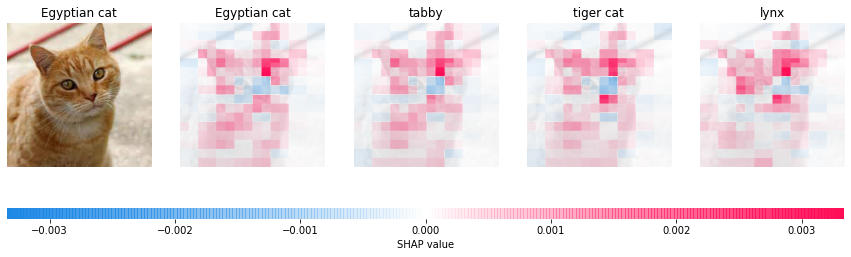

In [ ]:
shap.image_plot(shap_values=shap_values.values,
                pixel_values=shap_values.data,
                labels=shap_values.output_names,
                true_labels=[categories[285]])

## Captum Robustness

In [ ]:
from captum.attr import IntegratedGradients
from captum.attr import Saliency
from captum.attr import DeepLift
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

In [ ]:
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

img = Image.open('cat.jpeg')

img_tensor = transform(img)
img_tensor = img_tensor.unsqueeze(0)
img_tensor.requires_grad = True
img_tensor = img_tensor.to(device)

In [ ]:
img_tensor.requires_grad

True

In [ ]:
saliency = Saliency(model)
grads = saliency.attribute(img_tensor, target=285)
grads = np.transpose(grads.squeeze().cpu().detach().numpy(), (1, 2, 0))

In [ ]:
original_image = np.transpose((img_tensor.squeeze(0).cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))

In [ ]:
original_image.shape

(224, 224, 3)

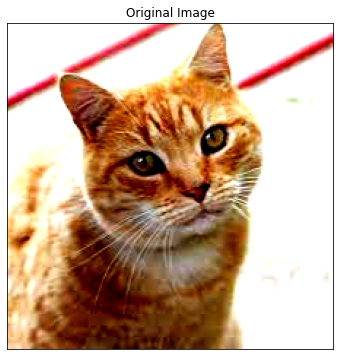

In [ ]:
_ = viz.visualize_image_attr(None, original_image, 
                      method="original_image", title="Original Image")

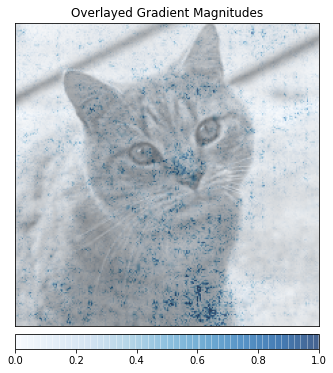

In [ ]:
_ = viz.visualize_image_attr(grads, original_image, method="blended_heat_map", sign="absolute_value",
                          show_colorbar=True, title="Overlayed Gradient Magnitudes")

In [ ]:
def attribute_image_features(algorithm, input, **kwargs):
    model.zero_grad()
    tensor_attributions = algorithm.attribute(input,
                                              target=285,
                                              **kwargs
                                             )
    
    return tensor_attributions
        

In [ ]:
ig = IntegratedGradients(model)
attr_ig, delta = attribute_image_features(ig, img_tensor, baselines=img_tensor * 0, return_convergence_delta=True)
attr_ig = np.transpose(attr_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))
print('Approximation delta: ', abs(delta))

Approximation delta:  tensor([0.0743], device='cuda:0', dtype=torch.float64)


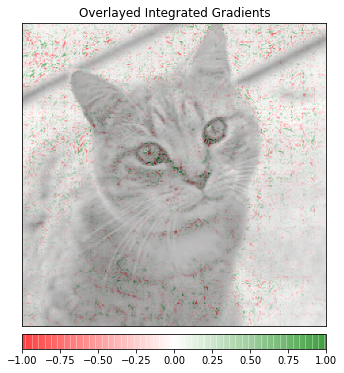

In [ ]:
_ = viz.visualize_image_attr(attr_ig, original_image, method="blended_heat_map", sign="all",
                          show_colorbar=True, title="Overlayed Integrated Gradients")

## Captum Model Robustness

In [ ]:
from captum.robust import FGSM
from captum.robust import PGD

In [ ]:
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

img = Image.open('cat.jpeg')

img_tensor = transform(img)
img_tensor = img_tensor.unsqueeze(0)
img_tensor.requires_grad = True
img_tensor = img_tensor.to(device)

In [ ]:
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]
inv_transform= T.Compose([
    T.Normalize(
        mean = (-1 * np.array(mean) / np.array(std)).tolist(),
        std = (1 / np.array(std)).tolist()
    ),
])

In [ ]:
def get_prediction(model, image: torch.Tensor):
    model = model.to(device)
    img_tensor = image.to(device)
    with torch.no_grad():
        output = model(img_tensor)
    output = F.softmax(output, dim=1)
    prediction_score, pred_label_idx = torch.topk(output, 1)

    pred_label_idx.squeeze_()
    predicted_label = categories[pred_label_idx.item()]

    return predicted_label, prediction_score.squeeze().item()

    # print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')

In [ ]:
# Get original prediction
pred, score  = get_prediction(model, img_tensor)

In [ ]:
def image_show(img, pred):
    npimg = inv_transform(img).squeeze().permute(1, 2, 0).detach().numpy()
    plt.imshow(npimg)
    plt.title("prediction: %s" % pred)
    plt.show()

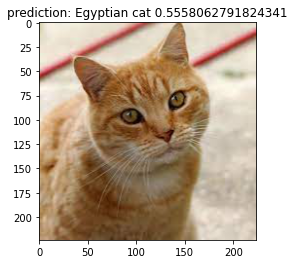

In [ ]:
image_show(img_tensor.cpu(), pred + " " + str(score))

In [ ]:
# Construct FGSM attacker
fgsm = FGSM(model, lower_bound=-1, upper_bound=1)
perturbed_image_fgsm = fgsm.perturb(img_tensor, epsilon=0.16, target=285) 
new_pred_fgsm, score_fgsm = get_prediction(model, perturbed_image_fgsm)

In [ ]:
# inv_transform(img_tensor).shape

torch.Size([1, 3, 224, 224])

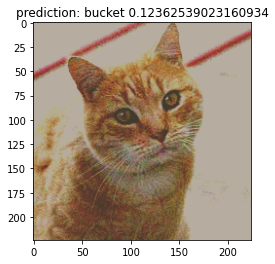

In [ ]:
image_show(perturbed_image_fgsm.cpu(), new_pred_fgsm + " " + str(score_fgsm))

In [ ]:
pgd = PGD(model, torch.nn.CrossEntropyLoss(reduction='none'), lower_bound=-1, upper_bound=1)  # construct the PGD attacker

perturbed_image_pgd = pgd.perturb(inputs=img_tensor, radius=0.13, step_size=0.02, 
                                  step_num=7, target=torch.tensor([199]).to(device), targeted=True) 
new_pred_pgd, score_pgd = get_prediction(model, perturbed_image_pgd)

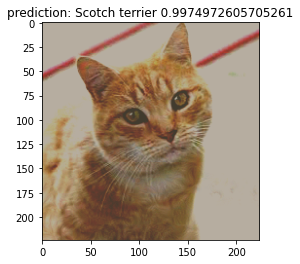

In [ ]:
image_show(perturbed_image_pgd.cpu(), new_pred_pgd + " " + str(score_pgd))

Feature Ablation

In [ ]:
feature_mask = torch.arange(64 *7*7).reshape(8*7, 8*7).repeat_interleave(repeats=4, dim=1).repeat_interleave(repeats=4, dim=0).reshape(1, 1, 224,224)
print(feature_mask)

tensor([[[[   0,    0,    0,  ...,   55,   55,   55],
          [   0,    0,    0,  ...,   55,   55,   55],
          [   0,    0,    0,  ...,   55,   55,   55],
          ...,
          [3080, 3080, 3080,  ..., 3135, 3135, 3135],
          [3080, 3080, 3080,  ..., 3135, 3135, 3135],
          [3080, 3080, 3080,  ..., 3135, 3135, 3135]]]])


In [ ]:
feature_mask.shape

torch.Size([1, 1, 224, 224])

In [ ]:
from captum.attr import FeatureAblation

ablator = FeatureAblation(model)
attr = ablator.attribute(img_tensor, target=285, feature_mask=feature_mask)
# Choose single channel, all channels have same attribution scores
pixel_attr = attr[:,0:1]

In [ ]:
def pixel_dropout(image, dropout_pixels):
    keep_pixels = image[0][0].numel() - int(dropout_pixels)
    vals, _ = torch.kthvalue(pixel_attr.flatten(), keep_pixels)
    return (pixel_attr < vals.item()) * image

In [ ]:
from captum.robust import MinParamPerturbation

min_pert_attr = MinParamPerturbation(forward_func=model, attack=pixel_dropout, arg_name="dropout_pixels", mode="linear",
                                     arg_min=0, arg_max=1024, arg_step=16,
                                     preproc_fn=None, apply_before_preproc=True)

In [ ]:
pixel_dropout_im, pixels_dropped = min_pert_attr.evaluate(img_tensor, target=285, perturbations_per_eval=10)
print("Minimum Pixels Dropped:", pixels_dropped)

Minimum Pixels Dropped: 480


In [ ]:
new_pred_dropout, score_dropout = get_prediction(model, pixel_dropout_im)

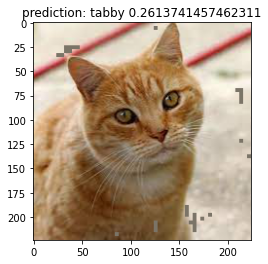

In [ ]:
image_show(pixel_dropout_im.cpu(), new_pred_dropout + " " + str(score_dropout))

Grad CAM

In [ ]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [ ]:
target_layers = [model.layer4[-1]]

In [ ]:
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)

In [ ]:
targets = [ClassifierOutputTarget(281)]

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=img_tensor, targets=targets)

In [ ]:
# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
rgb_img = inv_transform(img_tensor).cpu().squeeze().permute(1, 2, 0).detach().numpy()
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

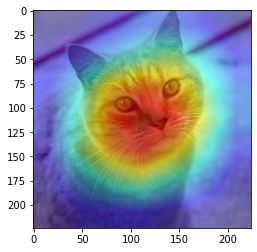

In [ ]:
plt.imshow(visualization)

In [ ]:
from pytorch_grad_cam import GradCAMPlusPlus

In [ ]:
cam = GradCAMPlusPlus(model=model, target_layers=target_layers, use_cuda=True)

In [ ]:
grayscale_cam = cam(input_tensor=img_tensor, targets=targets)

In [ ]:
# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
rgb_img = inv_transform(img_tensor).cpu().squeeze().permute(1, 2, 0).detach().numpy()
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

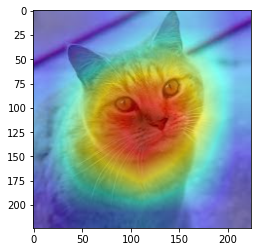

In [ ]:
plt.imshow(visualization)